# Generative Geographical Maps

After seeing [this](http://www-cs-students.stanford.edu/~amitp/game-programming/polygon-map-generation/) post on [Red Blob Games](http://www-cs-students.stanford.edu/~amitp/game-programming/polygon-map-generation/), I decided to give my own map generator a go.

In [175]:
#ignore
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import noise
from matplotlib.patches import Polygon
from matplotlib.collections import PolyCollection, PatchCollection
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from scipy.interpolate import interp1d, UnivariateSpline, splev, splprep

plt.rcParams['figure.figsize'] = [5.0,5.0]
print(plt.rcParams['figure.figsize'])

%matplotlib notebook

[5.0, 5.0]


## Starting with some (N) random points

I'm going to construct a Voronoi diagram in a similiar way as done here[^rblob1], minus the relaxation (I hope to get some more 'chaotic' terrain). I'm using the Voronoi implementation in Scipy[^scipyvoronoi].

[^rblob1]: [Polygon Generation from Voronoi Diagrams](http://www-cs-students.stanford.edu/~amitp/game-programming/polygon-map-generation/#polygons)

[^scipyvoronoi]: [scipy.spatial.Voronoi](http://scipy.github.io/devdocs/generated/scipy.spatial.Voronoi.html)

In [1308]:
seed = 55555
np.random.seed(seed)
N = 5000
# x, y coordinate pairs
pts = np.random.rand(N,2)
vor = Voronoi(pts)
#voronoi_plot_2d(vor)
plt.show()

In [1309]:
#ignore
biome_heights = {-0.4 : { 1.0 : "deep_sea" },
                -0.1: { 1.0 : "sea" },
                0.2 : { 0.15 : "trop_desert", 0.33 : "grassland", 0.66 : "trop_forest", 1.0 : "trop_rain_forest" },
                0.5 : { 0.15 : "desert", 0.66 : "grassland", 0.85 : "forest", 1.0 : "rain_forest" },
                0.7 : { 0.33 : "desert", 0.66: "shrubland", 1.0 : "taiga" },
                1.0 : { 0.1 : "scorched", 0.2 : "bare", 0.3 : "tundra", 1.0 : "snow" }
               }
biome_colors = {"deep_sea" : "#1F8BE0",
               "sea" : "#2196F3",
               "trop_rain_forest" : "#9CBBA9",
               "trop_forest" : "#A9CCA4",
               "grassland" : "#C4D4AA",
               "trop_desert" : "#E9DDC7",
               "rain_forest" : "#A4C4A8",
               "forest" : "#B4C9A9",
               "desert" : "#E4E8CA",
               "taiga" : "#CCD4BB",
               "shrubland" : "#C4CCBB",
               "snow" : "#FFFFFF",
               "tundra" : "#DDDDBB",
               "bare" : "#BBBBBB",
               "scorched" : "#999999"
               }

In [1310]:
#ignore
class Biome:
    """A biome region which is the smallest division of the map.
    It describes an area's heigt and humidity and is defined by a list of verticies."""
    id = 0
    center = []
    verts = []
    neighbors = []
    height = 0.0
    humidity = 0.0
    biome = "sea"
    outside = False
    owner = None
   
    def __init__(self, id, center, verts):
        self.id = id
        self.center = center
        self.verts = verts
        self.biome = "sea"
       
        # Normalize to 0-1
        self.humidity = (self.humidity + 1)/2
        self.neighbors = []
        self.outside = False
        owner = None
    
    def assign_biome(self, noise_seed, htscale, humscale,
                     pan=[0.0, 0.0], island=False):
         # Height determined by perlin noise
        self.height = noise.pnoise3(self.center[0]*htscale+pan[0],
                                    self.center[1]*htscale+pan[1],
                                    noise_seed)
        # Humidity determined by perlin noise too
        self.humidity = (noise.pnoise3(self.center[0]*humscale+pan[0],
                                      self.center[1]*humscale+pan[1],
                                      noise_seed+1)+1/2)
    
        if island:
            d = np.linalg.norm([self.center[0]-0.5, self.center[1]-0.5])
            self.height -= np.power(1.8*d,4)
        for h in reversed(sorted(biome_heights.keys())):
            if self.height < h:
                for hum in reversed(sorted(biome_heights[h].keys())):
                    if self.humidity < hum:
                        self.biome = biome_heights[h][hum]
                            
    def is_water(self):
        return self.biome == "sea"  or self.biome == "deep_sea"
    
    def __repr__(self):
        return self.biome

In [1311]:
#ignore
def draw_biomes(biomes):
    """Draws biome region polygons"""
    ax = plt.gca()
    # Polygon representations
    patches = []
    # Color data
    c = []
    for biome in biomes.values():
        if biome.outside:
            continue
            
        if not biome.is_water():
                ecolor = (0,0,0,0.1)
        else:
            ecolor = biome_colors[biome.biome]
                
        poly = Polygon(biome.verts, True,
                       facecolor=biome_colors[biome.biome])
        patches.append(poly)
        c.append(biome_colors[biome.biome])
    col = PatchCollection(patches)

    col.set_color(c)
    col.set_linewidth(1.0)
    #col.set_edgecolor((0,0,0,0.0))
    col.set_edgecolor('face')
    ax.add_collection(col)
    return ax


In [1312]:
#ignore
biomes = {}
# make point objects from the voronoi points and verticies
for i, pt in enumerate(vor.points):
    # The bounding verticies
    verts = vor.vertices[vor.regions[vor.point_region[i]]]
    
    biomes[i] = Biome(i, pt, verts)
    
    if -1 in vor.regions[vor.point_region[i]]:
        biomes[i].outside = True
    
for ridge in vor.ridge_points:
    biomes[ridge[0]].neighbors.append(biomes[ridge[1]])
    biomes[ridge[1]].neighbors.append(biomes[ridge[0]])

## Determining Biomes and Coloring

To start filling in the Voronoi cells, I first define some different biome reigions using a sort of Whittaker classification, although I'll use two dimensionless, normalized variables (I'll call them height and humidity) in place of precipitation and temperature. I also map each biome onto its own hex color to use when coloring in the map.

To determine these two variables, I use two perlin noise maps. Here I show the two noise maps and how they combine to produce biomes.

In [1313]:
#ignore
XX, YY = np.linspace(0,1,100), np.linspace(0,1,100)
mesh = np.meshgrid(XX,YY)
pnoise = np.vectorize(noise.pnoise3)
    
%matplotlib inline

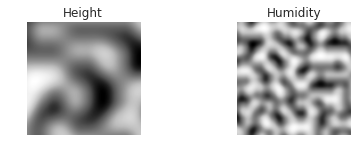

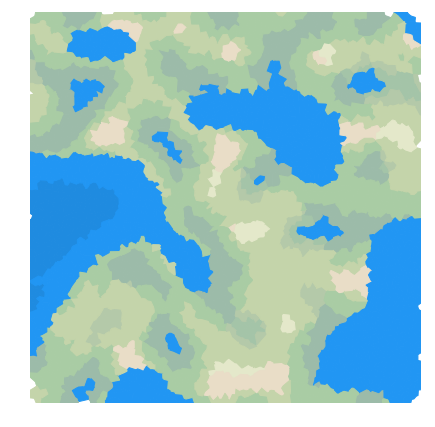

In [1314]:
#ignore
noise_seed = seed #116
htscale = 3.0
humscale = 8.0
pan = [ 0.5, 0.0 ]

for b in biomes.values():
    b.assign_biome(noise_seed, htscale, humscale, pan, False)

plt.subplot(2,2,1)
H = pnoise(mesh[0]*htscale+pan[0], mesh[1]*htscale+pan[1], noise_seed)
plt.imshow(np.flipud(H))
plt.title('Height')
plt.axis('off')

plt.subplot(2,2,2)
H = pnoise(mesh[0]*humscale+pan[0], mesh[1]*humscale+pan[1], noise_seed+1)
plt.title('Humidity')
plt.imshow(np.flipud(H))
plt.axis('off')
plt.tight_layout()

plt.figure(figsize=(7,7))
draw_biomes(biomes)
plt.gca().set_aspect(1)

plt.axis('off')
plt.show()

I also turn it into closed landforms by applying a radial fourth order drop-off.

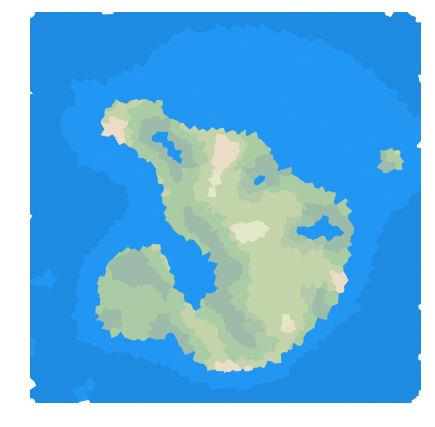

In [1315]:
#ignore
for b in biomes.values():
    b.assign_biome(noise_seed, htscale, humscale, pan, True)

plt.figure(figsize=(7,7))
draw_biomes(biomes)
plt.gca().set_aspect(1)

plt.axis('off')
plt.show()

## Adding Cities

Now that there's a relatively nice looking topology, I'll throw in some cities and provinces. I choose biome regions at random place cities according to a distribution that I've come up with (cities aren't as likely to be on the top of a mountain as they are to be on a flat plain). Here's that distribution as a probability as a function of the biome type:

In [1316]:
#ignore
city_probs = {"deep_sea" : 0.0,
               "sea" : 0.0,
               "trop_rain_forest" : 0.2,
               "trop_forest" : 0.5,
               "grassland" : 1.0,
               "trop_desert" : 0.5,
               "rain_forest" : 0.4,
               "forest" : 0.8,
               "desert" : 0.1,
               "taiga" : 0.5,
               "shrubland" : 0.9,
               "snow" : 0.1,
               "tundra" : 0.1,
               "bare" : 0.1,
               "scorched" : 0.1
               }

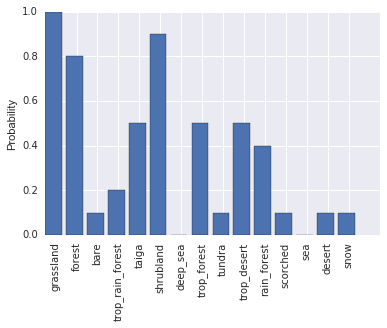

In [1317]:
#ignore
x = np.arange(0,len(city_probs.keys()))
plt.bar(x, list(city_probs.values()))
plt.xticks(x+0.5, list(city_probs.keys()), rotation=90)
plt.ylabel('Probability')
plt.show()

In [1318]:
#ignore
names = []
with open('names.txt', encoding='utf-8') as dat:
    reader = csv.reader(dat, delimiter=',')
    for row in reader:
        if row[1].isalpha():
            names.append(row[1])

In [1319]:
class City:
    name = 'city'
    biomes = []
    roads = []
    
    def __init__(self, name, biomes):
        self.name = name
        self.biomes = biomes
        for b in biomes:
            b.owner = self
        self.connected = []
        
    def grow(self):
        for b in range(len(self.biomes)):
            for n in self.biomes[b].neighbors:
                if n.is_water() or n.outside:
                    continue
                if n.owner is None:
                    self.biomes.append(n)
                    n.owner = self
        
    def __repr__(self):
        return '< City {} >'.format(self.name)
    

In [1320]:
#ignore
## MAKE CITIES
# reset biome owners
for b in biomes.values():
    b.owner = None

city_seed = seed #326548
np.random.seed(city_seed)
n_cities = 7
cities = {}
for b in biomes.values():
    if len(cities) >= n_cities:
        break
    if b.is_water() or b.outside:
        continue
    if np.random.rand() < city_probs[b.biome] and np.random.rand() < 0.05:
        n = np.random.choice(names, 1)[0]
        cities[n] = City(n, [b])
# Grow the city provinces
for i in range(25):
    for c in cities.values():
        c.grow()
print(cities)

{'Pasewalk': < City Pasewalk >, 'Milford': < City Milford >, 'Vizille': < City Vizille >, 'Lechlade': < City Lechlade >, 'Arab': < City Arab >, 'Conegliano': < City Conegliano >, 'Trenton': < City Trenton >}


In [1321]:
def draw_cities(cities):
    c_xy = [c.biomes[0].center for c in cities.values()]
    plt.plot(*zip(*c_xy), 'o', ms=10, mew=2, mfc=None)

    for name, c in cities.items():
        plt.annotate(name, c.biomes[0].center, xytext=(0,10),
                     textcoords='offset points',
                    ha='center')

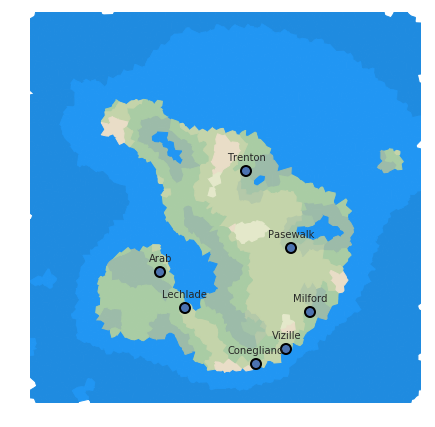

In [1322]:
#ignore
for b in biomes.values():
    b.assign_biome(noise_seed, htscale, humscale, pan, True)

plt.figure(figsize=(7,7))

draw_biomes(biomes)
draw_cities(cities)

plt.gca().set_aspect(1)
plt.axis('off')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [1323]:
def search_city_BFS(v, w, mcount=500):
    Q = [ v ]
    prev = {}
    visited = [ v ]
    # Don't allow crazy stuff
    count = 0
    while Q and count < mcount:
        count += 1
        # Next node
        u = Q.pop(0)
        # If found end city in current path
        if u == w:
            return prev
        
        next_n = sorted(u.neighbors, key=lambda b: abs(b.height - u.height))

        for n in next_n:
            if not n in visited and not n.is_water():
                visited.append(n)
                prev[n] = u
                # Add a new path to the queue with next neighbor at end
                Q.append(n)
    

In [1324]:
class Road:
    path = []
    
    def __init__(self, path):
        self.path = path
        
    def __repr__(self):
        return '< Road {} long >'.format(len(self.path))

In [1325]:
def road_to(start, goal, biomes, mcount=1000):
    route = search_city_BFS(start, goal, mcount)
    if not route:
        return None
    path = [ route[goal]  ]
    while not path[-1] == start:
        path.append(route[path[-1]])

    path.insert(0,goal)
    return Road(path)

In [1326]:
def draw_road(road):
    x = [ i.center[0] for i in road.path ]
    y = [ i.center[1] for i in road.path ]
    plt.plot(x,y, c=sns.xkcd_rgb['faded red'])

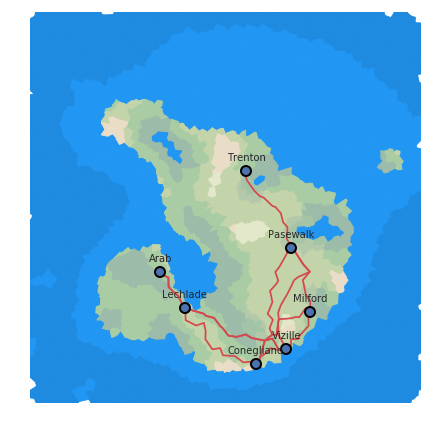

In [1332]:
plt.figure(figsize=(7,7))

draw_biomes(biomes)
for i in range(len(cities)):
    for j in range(i):
        start = list(cities.values())[i].biomes[0]
        goal = list(cities.values())[j].biomes[0]
        r = road_to(start, goal, biomes, 600)
        if r:
            list(cities.values())[i].roads.append(r)
            list(cities.values())[j].roads.append(r)
            draw_road(r)
            
            
draw_cities(cities)

plt.gca().set_aspect(1)
plt.axis('off')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [1328]:
#ignore
def draw_provinces(cities):
    ax = plt.gca()
    # Polygon representations
    # Color data
    cp = sns.color_palette('Set1',n_colors=len(cities))
    pats = ('-', '\\')
    for i, prov in enumerate(cities.values()):
        patches = []
        for b in prov.biomes: 
            if b.outside:
                continue
                
            poly = Polygon(b.verts, True)
            patches.append(poly)
        col = PatchCollection(patches)
        col.set_color(cp[i])
        col.set_linewidth(0)
        col.set_alpha(0.3)
        col.set_hatch(pats[i%len(pats)])
        col.set_edgecolor('face')
        ax.add_collection(col)
    
    #ax.add_collection(col)
    return ax


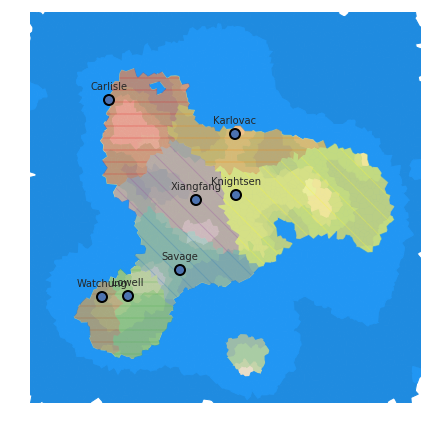

In [1306]:
plt.figure(figsize=(7,7))



draw_biomes(biomes)
draw_provinces(cities)
draw_cities(cities)
plt.gca().set_aspect(1)
plt.axis('off')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()